You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency
'r' can be real responses of RGC or form NGD.

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
def Histo3D2Dict(P):
    PDF = dict()
    for i in range(np.size(P, 0)):
        for j in range(np.size(P, 1)):
            for k in range(np.size(P, 2)):
                PDF[(k,i,j)] = float(P[i,j,k])
    return PDF

In [3]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [4]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [5]:
def Fake_Spike_Activation_function(realr, r, distribution, noise_list):
    rstate=np.zeros(len(r))
    model = 0
    if distribution == 'burst distributed':
        model += 10
    elif distribution == 'real distributed':
        model += 20
    elif distribution == 'fake distributed':
        model += 30
    for noise in noise_list:
        if noise == 'poisson process':
            model += 1
        elif noise == 'randomly not fire':
            model += 100
            
    if model == 121: #'randomly not fire' + 'real distributed' + 'poisson process'
        counter = 0
        for n in np.arange(1, max(realr)+1):
            edge = np.sort(r)[counter]
            counter += round((np.shape(np.where(realr==n))[1])/(len(r)-(np.shape(np.where(realr==0))[1]))*len(r))
            rstate[r>=edge] = np.random.poisson(n)
        randomly_not_fire = np.append(np.ones(len(r)-(np.shape(np.where(realr==0))[1])), np.zeros(np.shape(np.where(realr==0))[1]))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    elif model == 21: #'real distributed' + 'poisson process'
        counter = 0
        for n in np.unique(realr):
            edge = np.sort(r)[counter]
            counter += (np.shape(np.where(realr==n))[1])
            rstate[r>=edge] = np.random.poisson(n)
    elif model == 30: #'fake distributed' 
        edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
        rstate=np.zeros(len(r))
        for i in range(4):
            rstate[r>=edges[i]] = i
    elif model == 110: #'randomly not fire' + 'burst distributed' 
        counter = 0
        burst_distr = np.array([0.95, 0.03, 0.02]);
        for n in np.arange(1,3):
            edge = np.sort(r)[int(counter)]
            counter += int(len(r)*burst_distr[n]/(1-burst_distr[0])+0.5)
            rstate[r>=edge] = n
        randomly_not_fire = np.append(np.ones(int(len(r)*(1-burst_distr[0])+0.5)), np.zeros(int(len(r)*burst_distr[0]+0.5)))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    else:  #'real spike'
        rstate = np.nan
    return rstate

In [6]:
# activation function
def nA(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= 1
    return(y)

# activation function
def nA2(x,theta1, theta2):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta2>0:
            y[i]= 2
        elif x[i]- theta1>0:
            y[i]= 1
    return(y)

In [7]:
def STA(r, x, v, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    vSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        vSTS = vSTS + v[i+negshift:i+posshift]*r[i]
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    vSTA = vSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA, vSTA

In [8]:
def Get_StimulusnResponse(ExporSim, conPar, par_list, IndParValue=1, channelnumber = 39):
    rstate_list = []
    if ExporSim=='Exp':
        x_list = []
        T_list = []
        if conPar=='Gramma':
            for G in par_list:
                exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
                annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')
                x = np.squeeze(annots['bin_pos'])
                x = x.astype(float)
                x = (x-np.mean(x))/np.std(x)
                T = np.squeeze(annots['diode_BT'])
                rstate, _ = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
                rstate_list.append(rstate.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
            dt = 1/60
        elif conPar=='Fc':
            for Fc in par_list:
                exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408'
                annots = loadmat(exp_folder+'\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2')
                dt = 0.01
                sampling_rate = 20000
                TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
                TimeStamps = TimeStamps.astype(int)
                x = annots['a_data'][0, TimeStamps[0]*sampling_rate:TimeStamps[1]*sampling_rate+1]
                x = x[::int(sampling_rate*dt)]
                x = x.astype(float)
                T=np.arange(len(x))*dt
                rstate, _ = np.histogram(annots['Spikes'][0][channelnumber-1]-TimeStamps[0], np.append(0,T))
                rstate_list.append(rstate.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
    else:    ##'Sim':
        if conPar=='Tau':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            tau= 0.1
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            cutoffFreq = IndParValue
            for tau in par_list:
                for i in range(len(T)-1):
                    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
                # filtering for OUSmoothed
                LPOU_list = []
                b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        elif conPar=='Fc':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            tau= IndParValue
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            for i in range(len(T)-1):
                OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
            # filtering for OUSmoothed
            LPOU_list = []
            for cutoffFreq in par_list:
                b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        T_list = [T]*len(par_list)
    return x_list, T_list, dt, rstate_list


In [9]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = Gaussian(xx,sigma_dict['C'])
    KH = Gaussian(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))*dt
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])*dt
        output[i+1,:] = (output[i,:]+dyj)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

In [10]:
def Gaussian(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

# Main

Loading Exp.mat for position series

In [11]:
x_list, T_list, dt, prstate_list = Get_StimulusnResponse('Exp', 'Fc', [2,4,7,10],_, 53)
_, _, _, nprstate_list = Get_StimulusnResponse('Exp', 'Fc', [2,4,7,10],_, 36)
# x_list, T_list, dt, rstate_list = Get_StimulusnResponse('Exp', 'Gramma', [2.5,4.3,4.5,7.5,20],_, 21)
# x_list, T_list, dt, _ = Get_StimulusnResponse('Sim', 'Fc', [0.5,1,2,4,8], 1)
# x_list, T_list, dt, _ = Get_StimulusnResponse('Sim', 'Tau', [1.8,1.4,1,0.6,0.22], 1)

Calculate velocity

In [12]:
v_list = []
for i in range(len(x_list)):
    v = ndimage.gaussian_filter1d(x_list[i].copy(), sigma=5, order=1, mode='reflect') / dt
    v_list.append(v[1:-1].copy())    
    x_list[i] = x_list[i][1:-1]
    T_list[i] = T_list[i][1:-1]
    prstate_list[i] = prstate_list[i][1:-1]
    nprstate_list[i] = nprstate_list[i][1:-1]

Calculate correlation time

In [13]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3))

In [14]:
t_cor_list

[149.448, 149.447, 149.948, 149.448]

In [15]:
#assign states
ystate_list = []
xstate_list = []
vstate_list = []

for i in range(len(x_list)):
    xstate, _= EqualState(x_list[i], 6)
    vstate, _= EqualState(v_list[i], 6)
    xstate_list.append(xstate)
    vstate_list.append(vstate)

# Real Spike
Calculate information

In [16]:
window = [-1,1] # second
Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Information_list[i] = PIfunc(xstate_list[i], prstate_list[i], nprstate_list[i], dt, window)
timeshift = np.flip(timeshift)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

## Plot

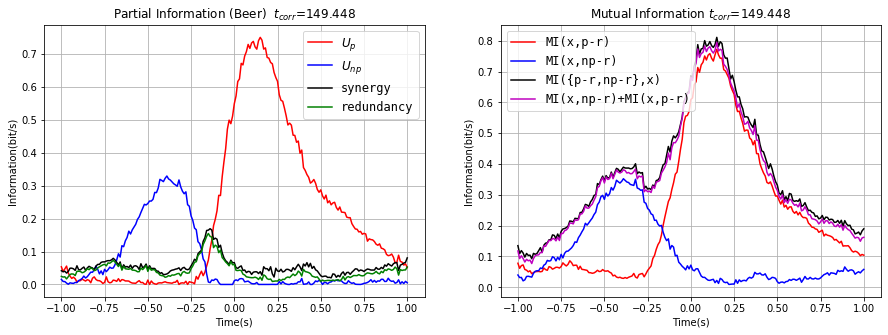

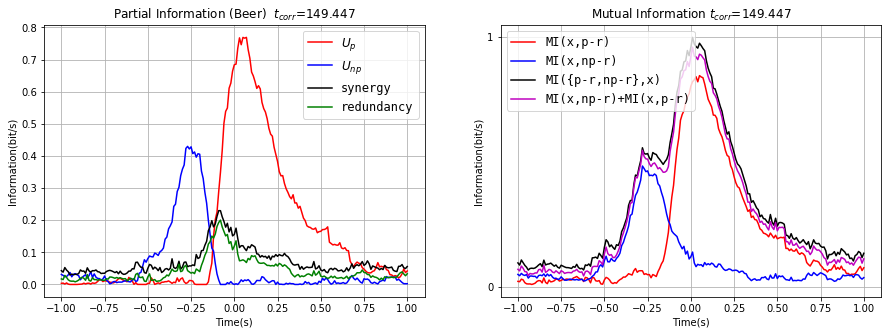

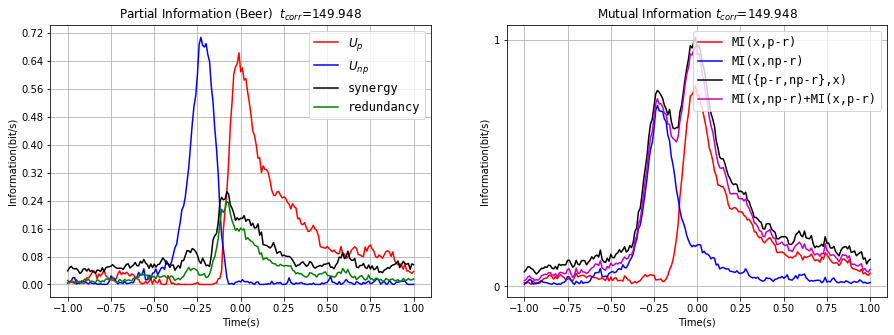

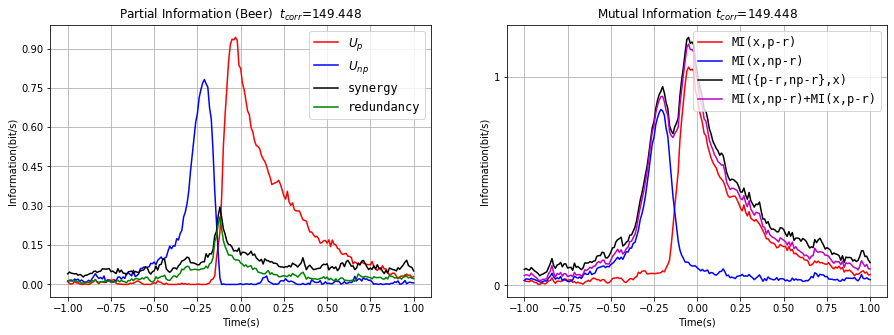

In [21]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_p$', r'$U_{np}$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,p)', 'MI(x,np)', 'MI({p,np},x)', 'MI(x,np)+MI(x,p)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

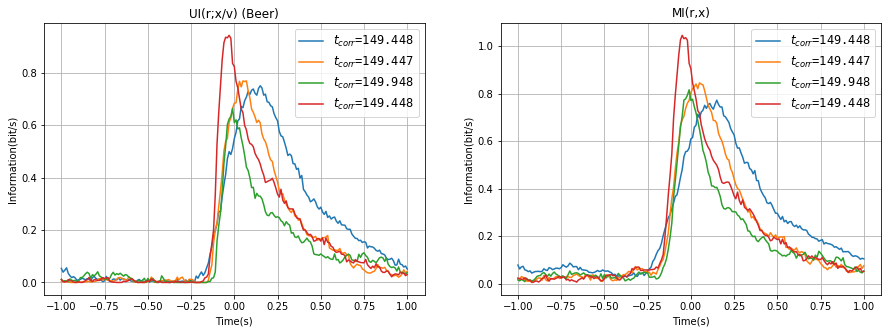

In [18]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

v

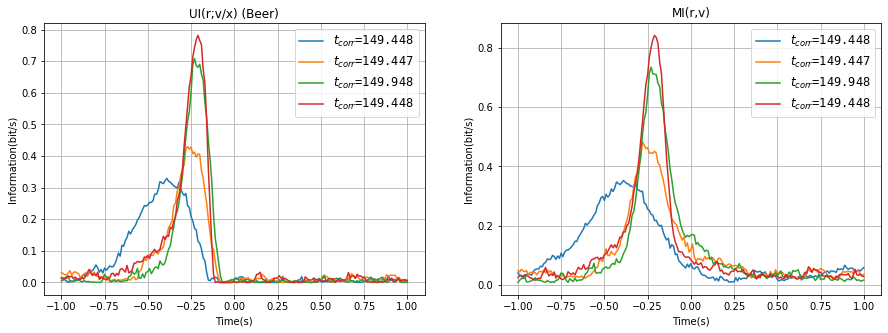

In [19]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;v/x) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,v)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.3, 0.3)
fig.set_size_inches(15, 5)

Synergy and MI(r;{x,v})

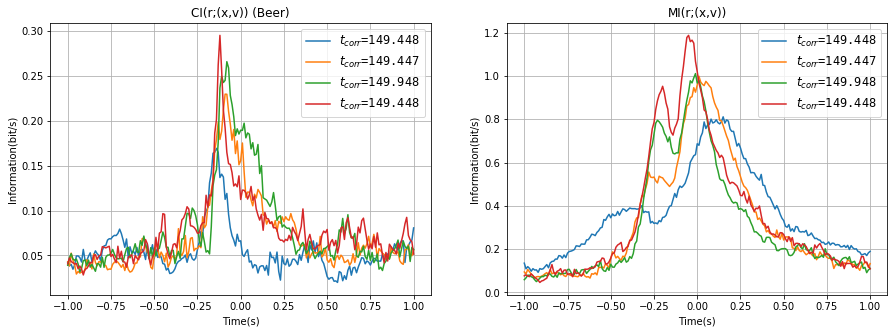

In [20]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('CI(r;(x,v)) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r;(x,v))')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.5, 0.2)
fig.set_size_inches(15, 5)